In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [2]:
# Read in the data
data = pd.read_csv('Product_Demand.csv', index_col='Date', parse_dates=True)
print(f"data shape: {data.shape}, data type: {data.dtypes}")
data.head()

data shape: (1048575, 4), data type: Product_Code        object
Warehouse           object
Product_Category    object
Order_Demand        object
dtype: object


,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-07-27,Product_0993,Whse_J,Category_028,100
2012-01-19,Product_0979,Whse_J,Category_028,500
2012-02-03,Product_0979,Whse_J,Category_028,500
2012-02-09,Product_0979,Whse_J,Category_028,500
2012-03-02,Product_0979,Whse_J,Category_028,500


In [3]:
category = data['Product_Category'].unique()
category.sort()
print(category)
#selecting a product from a category
products = data[data['Product_Category'] == category[0]]['Product_Code'].unique()
print(products)

['Category_001' 'Category_002' 'Category_003' 'Category_004'
 'Category_005' 'Category_006' 'Category_007' 'Category_008'
 'Category_009' 'Category_010' 'Category_011' 'Category_012'
 'Category_013' 'Category_014' 'Category_015' 'Category_016'
 'Category_017' 'Category_018' 'Category_019' 'Category_020'
 'Category_021' 'Category_022' 'Category_023' 'Category_024'
 'Category_025' 'Category_026' 'Category_027' 'Category_028'
 'Category_029' 'Category_030' 'Category_031' 'Category_032'
 'Category_033']
['Product_1938' 'Product_0613' 'Product_1763' 'Product_0616'
 'Product_0623' 'Product_0620' 'Product_1757' 'Product_0608'
 'Product_1752' 'Product_1755' 'Product_0601' 'Product_1935'
 'Product_0617' 'Product_1859' 'Product_0261' 'Product_0614'
 'Product_0622' 'Product_1870' 'Product_0631' 'Product_0632'
 'Product_1762' 'Product_1754' 'Product_1760' 'Product_0609'
 'Product_0405' 'Product_1869' 'Product_1875' 'Product_1861'
 'Product_0627' 'Product_0625' 'Product_0629' 'Product_0791'
 'Produ

In [4]:
df = data.loc[(data['Product_Code'] == products[0]) & (data['Product_Category'] == category[0]), ['Order_Demand']]
# df.set_index('Date', inplace=True)
# print(df['Product_Category'].unique().shape[0] == df.shape[0])
df['Order_Demand'] = df['Order_Demand'].str.replace('[^0-9-]', '').apply(pd.to_numeric)
print(df.dtypes)
df.head()
df.dtypes
df.describe()

Order_Demand    int64
dtype: object


,Order_Demand
count,929.000000
mean,4.410118
std,4.765260
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,40.000000


In [5]:
df.sort_index(inplace=True)
df.head()

,Order_Demand
Date,
2012-01-05,10
2012-01-05,5
2012-01-05,3
2012-01-05,1
2012-01-11,4


<AxesSubplot:xlabel='Date'>

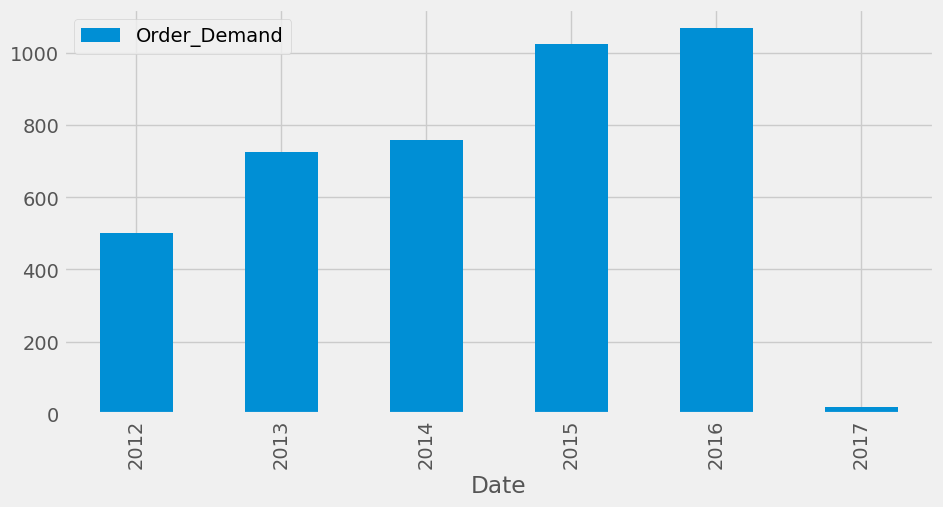

In [6]:
df.groupby(df.index.year).sum().plot(kind='bar', figsize=(10, 5))

<AxesSubplot:xlabel='Date'>

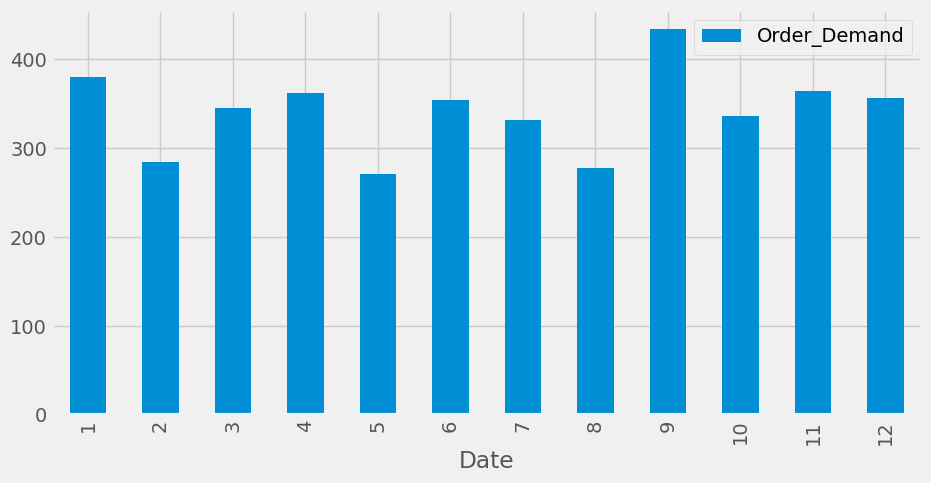

In [7]:
df.groupby(df.index.month).sum().plot(kind='bar', figsize=(10, 5))

In [8]:
df = df.groupby(df.index).sum()
df.head()

,Order_Demand
Date,
2012-01-05,19
2012-01-11,4
2012-01-13,7
2012-01-17,10
2012-01-24,8


In [9]:
# dickey fuller test
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(df['Order_Demand'])
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
if pval < 0.05:
    print('Reject null hypothesis, data is stationary')
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -3.2736080474211136
ADF p-values: 0.016100209173136037
Reject null hypothesis, data is stationary
ADF number of lags used: 15
ADF number of observations: 614
ADF critical values: {'1%': -3.4410451945636207, '5%': -2.8662587328558566, '10%': -2.569282988466721}
ADF best information criterion: 4079.0844963338423


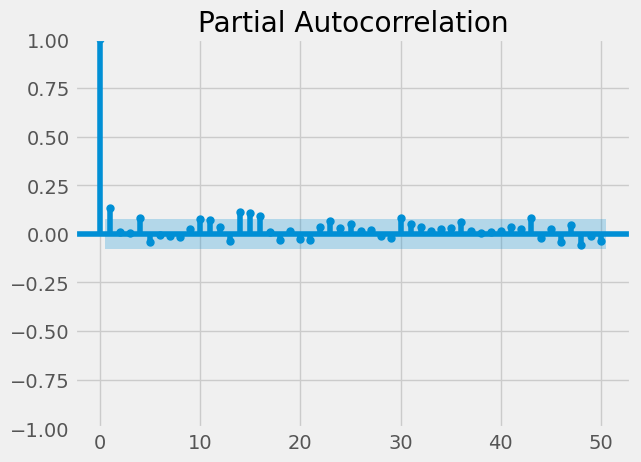

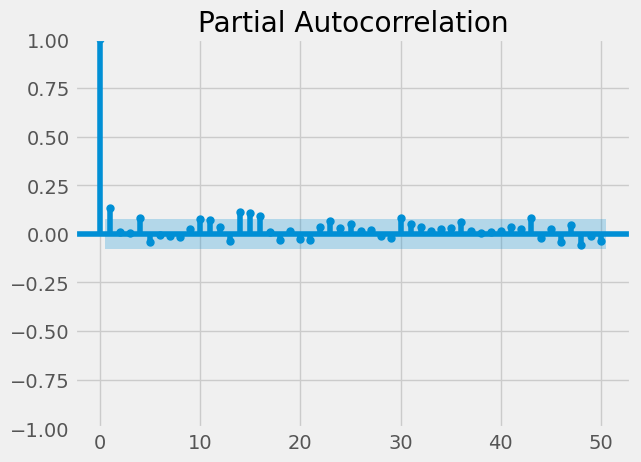

In [10]:
# plotting autocorrelation and partial autocorrelation

# plot_acf(df['Order_Demand'], lags=50)
plot_pacf(df['Order_Demand'], lags=50)

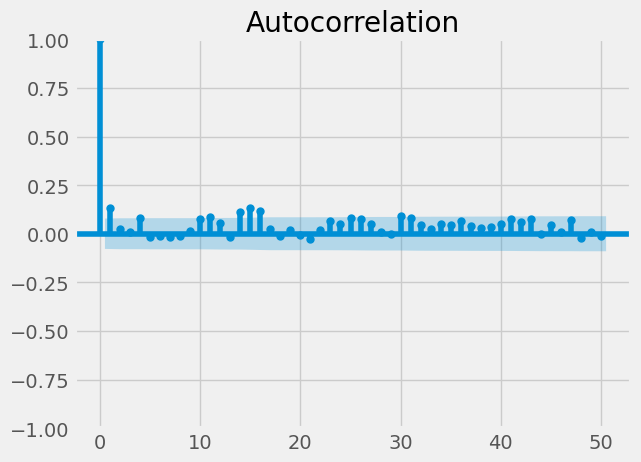

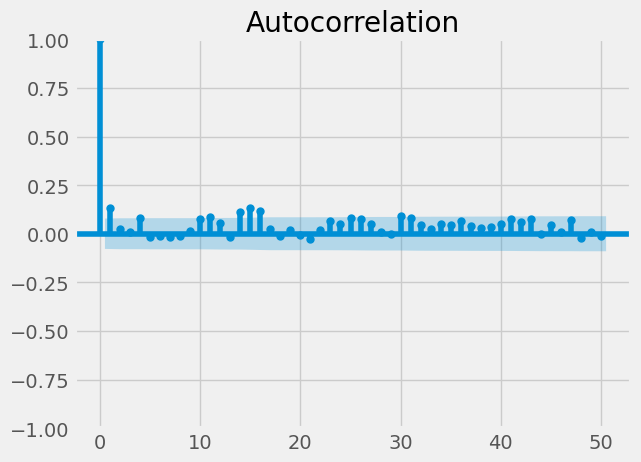

In [11]:
plot_acf(df['Order_Demand'], lags=50)

<AxesSubplot:xlabel='Date'>

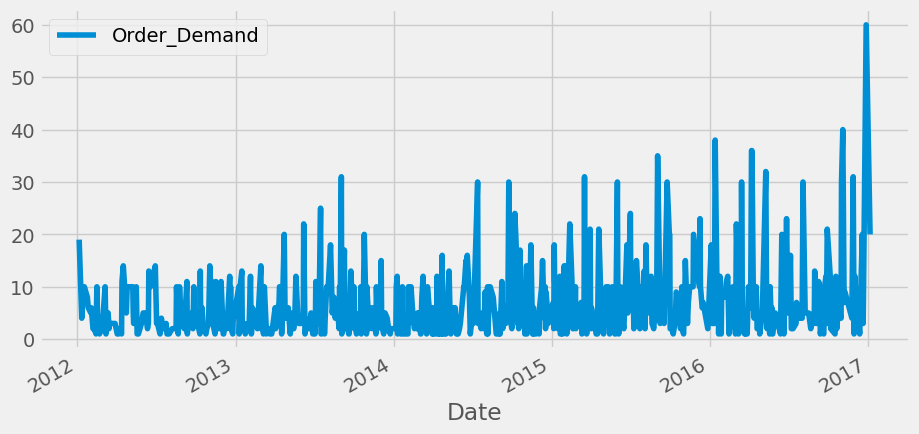

In [12]:
df.plot(figsize=(10, 5))

In [13]:
train = df[:len(df)-30]
test = df[len(df)-30:]

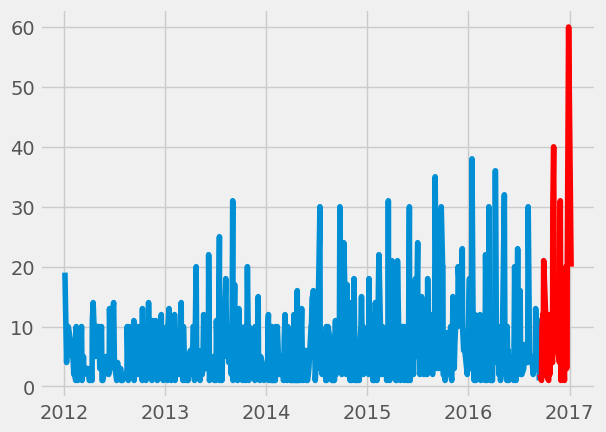

In [14]:
#plotting the train and test data
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='red')

In [15]:
model = ARIMA(train, order=(1, 0, 1)).fit()

In [16]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:           Order_Demand   No. Observations:                  600
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1953.332
Date:                Fri, 24 Mar 2023   AIC                           3914.665
Time:                        01:50:10   BIC                           3932.252
Sample:                             0   HQIC                          3921.511
                                - 600                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2523      0.462     13.538      0.000       5.347       7.158
ar.L1          0.2322      0.400      0.580      0.562      -0.552       1.016
ma.L1         -0.1202      0.414     -0.291      0.7

In [17]:
test.index[0]

Timestamp('2016-09-15 00:00:00')

In [18]:
# get the predictions start and end dates
pred_start = '2016-10-01'
pred_end= '2017-01-01'

# Make predictions
prediction = model.predict(start=pred_start, end=pred_end, typ='levels').rename('ARIMA Predictions')

# Get the residuals
residuals = test - prediction

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

NameError: name 'prediction' is not defined

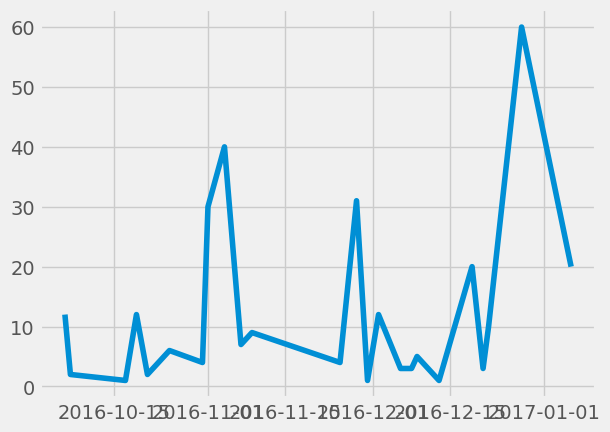

In [19]:
plt.plot(test[test.index > pred_start], label='Train')
plt.plot(prediction, label='Predictions', color='red')

In [20]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Order_Demand'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4562.836, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4419.582, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4560.836, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4362.951, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4310.610, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4302.666, Time=0.37 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4293.232, Time=0.47 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=4291.286, Time=0.21 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=4300.717, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=4199.904, Time=0.50 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=4201.901, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  630
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -2090.972
Date:                Fri, 24 Mar 2023   AIC                           4197.945
Time:                        01:50:39   BIC                           4233.498
Sample:                             0   HQIC                          4211.756
                                - 630                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7442      0.179      4.146      0.000       0.392       1.096
ar.L2         -0.1035      0.061     -1.711      0.087      -0.222       0.015
ar.L3         -0.0281      0.061     -0.457      0.648      -0.149       0.092
ar.L4          0.0786      0.044      1.798      0.072      -0.007       0.164
ar.L5         -0.1466      0.046     -3.177      0.001      -0.237      -0.056
ma.L1         -1.6322      0.175     -9.312      0.000      -1.976      -1.289
ma.L2          0.6475      0.172      3.771      0.000       0.311       0.984
sigma2        45.3064      1.463     30.966      0.000      42.439      48.174
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              2205.09
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               3.41   Skew:                             2.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""